# OCR Baseline using LPRNet (PyTorch)

This notebook implements the OCR pipeline using **LPRNet**, a lightweight Convolutional Neural Network designed for License Plate Recognition.

**Current Configuration**
- **Batch Size**: 16
- **Mixed Precision**: Enabled (AMP)
- **Workers**: 2
- **Progress Tracking**: TQDM enabled
- **Metrics**: Sequence/Greedy Acc, Char Acc, Edit Distance

**Steps:**
1. **Setup**: Import libraries and Modules.
2. **Data**: Load dataset using custom `LPRDataset`.
3. **Model**: Initialize `LPRNet`.
4. **Training**: Train the model using CTC Loss with AMP.
5. **Inference**: Evaluate on validation set.

In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler # Mixed Precision
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import random

# for valid comparison of various configurations experiment
SEED = 2025
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

# init worker
def seed_worker(worker_id):
    # Fix for OpenCV-PyTorch deadlock/thrashing
    import cv2
    cv2.setNumThreads(0)
    
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
# Generator
g = torch.Generator()
g.manual_seed(SEED)

## 1. Setup

In [2]:
# Add src to path if needed
sys.path.append('..')

from src.ocr.lprnet import build_lprnet
from src.ocr.reader import LPRDataset, collate_fn
from src.ocr.decoder import LPRLabelEncoder, CHARS
from src.evaluation.metrics import compute_ocr_metrics

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check CUDA Capability
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.20 GB


## 2. Dataset Preparation

In [ ]:
DATASET_DIR = "../datasets/preprocessed/plate_text_cropped"
IMAGES_DIR = os.path.join(DATASET_DIR, "dataset")
LABEL_FILE = os.path.join(DATASET_DIR, "label.csv")

BATCH_SIZE = 16 
NUM_WORKERS = 2 
PIN_MEMORY = True # Speed up host-to-device transfer

IMG_SIZE = (94, 24) # LPRNet standard input size

# 1. Initialize base dataset just for length (no transform yet)
base_dataset = LPRDataset(img_dir=IMAGES_DIR, label_file=LABEL_FILE, img_size=IMG_SIZE)

# 2. Calculate split sizes
train_size = int(0.8 * len(base_dataset))
val_size = len(base_dataset) - train_size

# 3. Use random_split to generate random INDICES (using the generator for reproducibility)
train_subset_base, val_subset_base = torch.utils.data.random_split(base_dataset, [train_size, val_size], generator=g)

# 4. Instantiate separate datasets for Train (Augmented) and Val (Clean)
# Note: They verify against the same files, but have different transform logic
train_ds_full = LPRDataset(img_dir=IMAGES_DIR, label_file=LABEL_FILE, img_size=IMG_SIZE, augmentation=True)
val_ds_full = LPRDataset(img_dir=IMAGES_DIR, label_file=LABEL_FILE, img_size=IMG_SIZE, augmentation=False)

# 5. Create final Subsets using the SAME indices from step 3
train_dataset = torch.utils.data.Subset(train_ds_full, train_subset_base.indices)
val_dataset = torch.utils.data.Subset(val_ds_full, val_subset_base.indices)

print(f"Train Dataset: {len(train_dataset)} samples (Augmented)")
print(f"Val Dataset: {len(val_dataset)} samples (Clean)")

# Dataloaders
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          collate_fn=collate_fn, 
                          num_workers=NUM_WORKERS, 
                          pin_memory=PIN_MEMORY, 
                          persistent_workers=True,
                          worker_init_fn=seed_worker,
                          generator=g)

val_loader = DataLoader(val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False, 
                        collate_fn=collate_fn, 
                        num_workers=NUM_WORKERS, 
                        pin_memory=PIN_MEMORY,
                        persistent_workers=True,
                        worker_init_fn=seed_worker,
                        generator=g)

Train Dataset: 1490 samples (Augmented)
Val Dataset: 373 samples (Clean)


## 3. Model Initialization

In [ ]:
lpr_max_len = 18 # Maximum length of license plate
class_num = len(CHARS) + 1 # +1 for blank

model = build_lprnet(lpr_max_len=lpr_max_len, class_num=class_num, dropout_rate=0.5)
model.to(device)

LPRNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (4): SmallBasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        (3): ReLU()
        (4): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        (5): ReLU()
        (6): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool3d(kernel_size=(1, 3, 3), stride=(2, 1, 2), padding=0, dilation=1, ceil_mode=False)
    (8): SmallBasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kern

## 4. Training Loop (with AMP & TQDM)

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler, epoch):
    model.train()
    total_loss = 0.0
    
    # Metrics accumulator
    total_seq_acc = 0.0
    total_char_acc = 0.0
    num_batches = 0
    
    encoder = LPRLabelEncoder(CHARS)

    pbar = tqdm(loader, desc=f"Train Epoch {epoch+1}", leave=False)

    for images, labels, lengths in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        lengths = lengths.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            logits = model(images)                 # (B, C, T)
            log_probs = logits.permute(2, 0, 1)    # (T, B, C)
            log_probs = log_probs.log_softmax(2)

            input_lengths = torch.full(
                size=(images.size(0),),
                fill_value=logits.size(2),
                dtype=torch.long,
                device=device
            )

            loss = criterion(log_probs, labels, input_lengths, lengths)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        

        # Calculate Train Metrics on the Fly ---
        # Decode greedy for rough estimation while training
        with torch.no_grad():
            preds_decoded = encoder.decode_greedy(logits)
            
            # Reconstruct targets text
            labels_cpu = labels.cpu().numpy()
            lengths_cpu = lengths.cpu().numpy()
            targets_decoded = []
            idx = 0
            for le in lengths_cpu:
                targets_decoded.append("".join([CHARS[c] for c in labels_cpu[idx:idx+le]]))
                idx += le
                
            # Compute Batch Metrics
            batch_metrics = compute_ocr_metrics(preds_decoded, targets_decoded)
            total_seq_acc += batch_metrics["seq_acc"]
            total_char_acc += batch_metrics["char_acc"]
            num_batches += 1

        total_loss += loss.item()
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}", 
            "acc": f"{batch_metrics['seq_acc']:.2%}"
        })

    avg_loss = total_loss / num_batches
    avg_seq_acc = total_seq_acc / num_batches
    avg_char_acc = total_char_acc / num_batches
    
    return avg_loss, avg_seq_acc, avg_char_acc

def evaluate(model, loader, device):
    model.eval()
    encoder = LPRLabelEncoder(CHARS)

    all_preds = []
    all_targets = []

    pbar = tqdm(loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for images, labels, lengths in pbar:
            images = images.to(device, non_blocking=True)

            with autocast():
                logits = model(images)

            preds = encoder.decode_greedy(logits)

            labels = labels.cpu().numpy()
            lengths = lengths.cpu().numpy()

            idx = 0
            for i, length in enumerate(lengths):
                true_indices = labels[idx : idx + length]
                true_text = "".join([CHARS[j] for j in true_indices])
                idx += length

                all_preds.append(preds[i])
                all_targets.append(true_text)

    metrics = compute_ocr_metrics(all_preds, all_targets)
    return metrics

In [ ]:
num_epochs = 100
patience = 15
best_seq_acc = 0.0
epochs_no_improve = 0

save_dir = "../artifacts/lprnet"
os.makedirs(save_dir, exist_ok=True)

criterion = nn.CTCLoss(blank=len(CHARS), reduction='mean')

optimizer = optim.Adam(
    model.parameters(),
    lr=0.001
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=20,
    gamma=0.5
)

scaler = GradScaler()


# History Storage
history = {
    "train_loss": [],
    "train_seq_acc": [],
    "val_seq_acc": [],
    "train_char_acc": [],
    "val_char_acc": [],
    "val_edit_dist": []
}

print("Starting Training...\n")

for epoch in range(num_epochs):
    train_loss, train_seq_acc, train_char_acc = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        device,
        scaler,
        epoch
    )
    
    scheduler.step()
    
    # Evaluate
    metrics = evaluate(model, val_loader, device)
    val_seq_acc = metrics["seq_acc"]
    val_char_acc = metrics["char_acc"]
    val_edit_dist = metrics["avg_edit_dist"]
    
    history["train_loss"].append(train_loss)
    history["train_seq_acc"].append(train_seq_acc)
    history["val_seq_acc"].append(val_seq_acc)
    history["train_char_acc"].append(train_char_acc)
    history["val_char_acc"].append(val_char_acc)
    history["val_edit_dist"].append(val_edit_dist)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Loss: {train_loss:.4f} | "
        f"Train Acc: {train_seq_acc:.4f} | "  
        f"Val Acc: {val_seq_acc:.4f} | "      
        f"Val Char: {val_char_acc:.4f} | "
        f"Edit Dist: {val_edit_dist:.4f}"
    )

    # Save Best Model based on Val Seq Accuracy
    if val_seq_acc > best_seq_acc:
        best_seq_acc = val_seq_acc
        epochs_no_improve = 0
        torch.save(
            model.state_dict(),
            os.path.join(save_dir, "lprnet_best.pth")
        )
        print(f"Best model saved (Seq Acc: {best_seq_acc:.4f})")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

# Save Last
torch.save(
    model.state_dict(),
    os.path.join(save_dir, "lprnet_last.pth")
)
print("\nTraining finished")
print(f"Best Seq Accuracy: {best_seq_acc:.4f}")
print(f"Models saved in: {save_dir}")

Starting Training...



Epoch [1/100] Loss: 3.6491 | Train Acc: 0.0000 | Val Acc: 0.0000 | Val Char: 0.0757 | Edit Dist: 6.8391


Epoch [2/100] Loss: 3.2640 | Train Acc: 0.0000 | Val Acc: 0.0000 | Val Char: 0.0764 | Edit Dist: 6.8338


Epoch [3/100] Loss: 3.0574 | Train Acc: 0.0000 | Val Acc: 0.0000 | Val Char: 0.1047 | Edit Dist: 6.6247


Epoch [4/100] Loss: 2.7966 | Train Acc: 0.0000 | Val Acc: 0.0000 | Val Char: 0.2167 | Edit Dist: 5.7962


Epoch [5/100] Loss: 2.5510 | Train Acc: 0.0000 | Val Acc: 0.0000 | Val Char: 0.2083 | Edit Dist: 5.8579


Epoch [6/100] Loss: 2.3161 | Train Acc: 0.0007 | Val Acc: 0.0000 | Val Char: 0.4051 | Edit Dist: 4.4021


Epoch [7/100] Loss: 2.0855 | Train Acc: 0.0066 | Val Acc: 0.0080 | Val Char: 0.4750 | Edit Dist: 3.8847
Best model saved (Seq Acc: 0.0080)


Epoch [8/100] Loss: 1.9511 | Train Acc: 0.0027 | Val Acc: 0.0080 | Val Char: 0.5630 | Edit Dist: 3.2332


Epoch [9/100] Loss: 1.8389 | Train Acc: 0.0086 | Val Acc: 0.0080 | Val Char: 0.5746 | Edit Dist: 3.1475


Epoch [10/100] Loss: 1.7868 | Train Acc: 0.0066 | Val Acc: 0.0134 | Val Char: 0.5743 | Edit Dist: 3.1501
Best model saved (Seq Acc: 0.0134)


Epoch [11/100] Loss: 1.6870 | Train Acc: 0.0266 | Val Acc: 0.0429 | Val Char: 0.6043 | Edit Dist: 2.9276
Best model saved (Seq Acc: 0.0429)


Epoch [12/100] Loss: 1.5608 | Train Acc: 0.0831 | Val Acc: 0.1180 | Val Char: 0.6688 | Edit Dist: 2.4504
Best model saved (Seq Acc: 0.1180)


Epoch [13/100] Loss: 1.4688 | Train Acc: 0.1097 | Val Acc: 0.0992 | Val Char: 0.6333 | Edit Dist: 2.7131


Epoch [14/100] Loss: 1.4286 | Train Acc: 0.1223 | Val Acc: 0.1689 | Val Char: 0.6812 | Edit Dist: 2.3592
Best model saved (Seq Acc: 0.1689)


Epoch [15/100] Loss: 1.3081 | Train Acc: 0.1596 | Val Acc: 0.1930 | Val Char: 0.6819 | Edit Dist: 2.3539
Best model saved (Seq Acc: 0.1930)


Epoch [16/100] Loss: 1.2283 | Train Acc: 0.1868 | Val Acc: 0.2225 | Val Char: 0.7210 | Edit Dist: 2.0643
Best model saved (Seq Acc: 0.2225)


Epoch [17/100] Loss: 1.1782 | Train Acc: 0.2114 | Val Acc: 0.2386 | Val Char: 0.7362 | Edit Dist: 1.9517
Best model saved (Seq Acc: 0.2386)


Epoch [18/100] Loss: 1.1578 | Train Acc: 0.2055 | Val Acc: 0.2493 | Val Char: 0.7420 | Edit Dist: 1.9088
Best model saved (Seq Acc: 0.2493)


Epoch [19/100] Loss: 1.1299 | Train Acc: 0.2174 | Val Acc: 0.2413 | Val Char: 0.7203 | Edit Dist: 2.0697


Epoch [20/100] Loss: 1.0825 | Train Acc: 0.2214 | Val Acc: 0.2466 | Val Char: 0.7101 | Edit Dist: 2.1448


Epoch [21/100] Loss: 1.0220 | Train Acc: 0.2746 | Val Acc: 0.3512 | Val Char: 0.7848 | Edit Dist: 1.5925
Best model saved (Seq Acc: 0.3512)


Epoch [22/100] Loss: 0.9520 | Train Acc: 0.3019 | Val Acc: 0.3458 | Val Char: 0.7848 | Edit Dist: 1.5925


Epoch [23/100] Loss: 0.9445 | Train Acc: 0.3092 | Val Acc: 0.3458 | Val Char: 0.7736 | Edit Dist: 1.6756


Epoch [24/100] Loss: 0.9376 | Train Acc: 0.3059 | Val Acc: 0.3458 | Val Char: 0.7783 | Edit Dist: 1.6408


Epoch [25/100] Loss: 0.9353 | Train Acc: 0.3185 | Val Acc: 0.3458 | Val Char: 0.7957 | Edit Dist: 1.5121


Epoch [26/100] Loss: 0.8959 | Train Acc: 0.3291 | Val Acc: 0.3566 | Val Char: 0.8011 | Edit Dist: 1.4718
Best model saved (Seq Acc: 0.3566)


Epoch [27/100] Loss: 0.8912 | Train Acc: 0.3351 | Val Acc: 0.3941 | Val Char: 0.8029 | Edit Dist: 1.4584
Best model saved (Seq Acc: 0.3941)


Epoch [28/100] Loss: 0.8906 | Train Acc: 0.3464 | Val Acc: 0.3566 | Val Char: 0.7982 | Edit Dist: 1.4933


Epoch [29/100] Loss: 0.8574 | Train Acc: 0.3477 | Val Acc: 0.4048 | Val Char: 0.8087 | Edit Dist: 1.4155
Best model saved (Seq Acc: 0.4048)


Epoch [30/100] Loss: 0.8625 | Train Acc: 0.3564 | Val Acc: 0.3887 | Val Char: 0.8029 | Edit Dist: 1.4584


Epoch [31/100] Loss: 0.8600 | Train Acc: 0.3504 | Val Acc: 0.3914 | Val Char: 0.8072 | Edit Dist: 1.4263


Epoch [32/100] Loss: 0.8363 | Train Acc: 0.3557 | Val Acc: 0.4102 | Val Char: 0.8083 | Edit Dist: 1.4182
Best model saved (Seq Acc: 0.4102)


Epoch [33/100] Loss: 0.8436 | Train Acc: 0.3484 | Val Acc: 0.3941 | Val Char: 0.8170 | Edit Dist: 1.3539


Epoch [34/100] Loss: 0.8120 | Train Acc: 0.3717 | Val Acc: 0.4236 | Val Char: 0.8185 | Edit Dist: 1.3432
Best model saved (Seq Acc: 0.4236)


Epoch [35/100] Loss: 0.7846 | Train Acc: 0.3770 | Val Acc: 0.3861 | Val Char: 0.8054 | Edit Dist: 1.4397


Epoch [36/100] Loss: 0.7545 | Train Acc: 0.3830 | Val Acc: 0.4021 | Val Char: 0.8141 | Edit Dist: 1.3753


Epoch [37/100] Loss: 0.7747 | Train Acc: 0.3969 | Val Acc: 0.3914 | Val Char: 0.8203 | Edit Dist: 1.3298


Epoch [38/100] Loss: 0.7904 | Train Acc: 0.4009 | Val Acc: 0.4209 | Val Char: 0.8152 | Edit Dist: 1.3673


Epoch [39/100] Loss: 0.7589 | Train Acc: 0.4176 | Val Acc: 0.4397 | Val Char: 0.8261 | Edit Dist: 1.2869
Best model saved (Seq Acc: 0.4397)


Epoch [40/100] Loss: 0.7882 | Train Acc: 0.3823 | Val Acc: 0.4075 | Val Char: 0.8221 | Edit Dist: 1.3164


Epoch [41/100] Loss: 0.7209 | Train Acc: 0.4395 | Val Acc: 0.4397 | Val Char: 0.8319 | Edit Dist: 1.2440


Epoch [42/100] Loss: 0.7070 | Train Acc: 0.4475 | Val Acc: 0.4531 | Val Char: 0.8359 | Edit Dist: 1.2145
Best model saved (Seq Acc: 0.4531)


Epoch [43/100] Loss: 0.6809 | Train Acc: 0.4621 | Val Acc: 0.4611 | Val Char: 0.8315 | Edit Dist: 1.2466
Best model saved (Seq Acc: 0.4611)


Epoch [44/100] Loss: 0.6788 | Train Acc: 0.4608 | Val Acc: 0.4584 | Val Char: 0.8370 | Edit Dist: 1.2064


Epoch [45/100] Loss: 0.7145 | Train Acc: 0.4495 | Val Acc: 0.4665 | Val Char: 0.8337 | Edit Dist: 1.2306
Best model saved (Seq Acc: 0.4665)


Epoch [46/100] Loss: 0.6941 | Train Acc: 0.4694 | Val Acc: 0.4772 | Val Char: 0.8409 | Edit Dist: 1.1769
Best model saved (Seq Acc: 0.4772)


Epoch [47/100] Loss: 0.6799 | Train Acc: 0.4661 | Val Acc: 0.4879 | Val Char: 0.8467 | Edit Dist: 1.1340
Best model saved (Seq Acc: 0.4879)


Epoch [48/100] Loss: 0.6855 | Train Acc: 0.4840 | Val Acc: 0.4397 | Val Char: 0.8351 | Edit Dist: 1.2198


Epoch [49/100] Loss: 0.6698 | Train Acc: 0.4614 | Val Acc: 0.4665 | Val Char: 0.8435 | Edit Dist: 1.1582


Epoch [50/100] Loss: 0.6773 | Train Acc: 0.4781 | Val Acc: 0.4745 | Val Char: 0.8431 | Edit Dist: 1.1609


Epoch [51/100] Loss: 0.6806 | Train Acc: 0.4601 | Val Acc: 0.4665 | Val Char: 0.8424 | Edit Dist: 1.1662


Epoch [52/100] Loss: 0.6360 | Train Acc: 0.4781 | Val Acc: 0.4879 | Val Char: 0.8453 | Edit Dist: 1.1448


Epoch [53/100] Loss: 0.6502 | Train Acc: 0.4787 | Val Acc: 0.4826 | Val Char: 0.8417 | Edit Dist: 1.1716


Epoch [54/100] Loss: 0.6315 | Train Acc: 0.5047 | Val Acc: 0.4987 | Val Char: 0.8471 | Edit Dist: 1.1314
Best model saved (Seq Acc: 0.4987)


Epoch [55/100] Loss: 0.6192 | Train Acc: 0.5020 | Val Acc: 0.4745 | Val Char: 0.8438 | Edit Dist: 1.1555


Epoch [56/100] Loss: 0.6549 | Train Acc: 0.4727 | Val Acc: 0.4906 | Val Char: 0.8457 | Edit Dist: 1.1421


Epoch [57/100] Loss: 0.6695 | Train Acc: 0.4854 | Val Acc: 0.4692 | Val Char: 0.8388 | Edit Dist: 1.1930


Epoch [58/100] Loss: 0.6366 | Train Acc: 0.4747 | Val Acc: 0.4718 | Val Char: 0.8464 | Edit Dist: 1.1367


Epoch [59/100] Loss: 0.6988 | Train Acc: 0.4807 | Val Acc: 0.4638 | Val Char: 0.8467 | Edit Dist: 1.1340


Epoch [60/100] Loss: 0.6111 | Train Acc: 0.4914 | Val Acc: 0.4960 | Val Char: 0.8471 | Edit Dist: 1.1314


Epoch [61/100] Loss: 0.6498 | Train Acc: 0.5007 | Val Acc: 0.4906 | Val Char: 0.8504 | Edit Dist: 1.1072


Epoch [62/100] Loss: 0.5725 | Train Acc: 0.5213 | Val Acc: 0.5201 | Val Char: 0.8540 | Edit Dist: 1.0804
Best model saved (Seq Acc: 0.5201)


Epoch [63/100] Loss: 0.5740 | Train Acc: 0.5259 | Val Acc: 0.5201 | Val Char: 0.8576 | Edit Dist: 1.0536


Epoch [64/100] Loss: 0.6129 | Train Acc: 0.5160 | Val Acc: 0.5147 | Val Char: 0.8558 | Edit Dist: 1.0670


Epoch [65/100] Loss: 0.5909 | Train Acc: 0.5080 | Val Acc: 0.5094 | Val Char: 0.8551 | Edit Dist: 1.0724


Epoch [66/100] Loss: 0.5670 | Train Acc: 0.5126 | Val Acc: 0.5094 | Val Char: 0.8572 | Edit Dist: 1.0563


Epoch [67/100] Loss: 0.5563 | Train Acc: 0.5445 | Val Acc: 0.4960 | Val Char: 0.8496 | Edit Dist: 1.1126


Epoch [68/100] Loss: 0.5898 | Train Acc: 0.5312 | Val Acc: 0.5174 | Val Char: 0.8565 | Edit Dist: 1.0617


Epoch [69/100] Loss: 0.5795 | Train Acc: 0.5366 | Val Acc: 0.5228 | Val Char: 0.8616 | Edit Dist: 1.0241
Best model saved (Seq Acc: 0.5228)


Epoch [70/100] Loss: 0.5926 | Train Acc: 0.5412 | Val Acc: 0.5174 | Val Char: 0.8558 | Edit Dist: 1.0670


Epoch [71/100] Loss: 0.6490 | Train Acc: 0.5219 | Val Acc: 0.5335 | Val Char: 0.8576 | Edit Dist: 1.0536
Best model saved (Seq Acc: 0.5335)


Epoch [72/100] Loss: 0.5591 | Train Acc: 0.5512 | Val Acc: 0.5228 | Val Char: 0.8627 | Edit Dist: 1.0161


Epoch [73/100] Loss: 0.5839 | Train Acc: 0.5386 | Val Acc: 0.5255 | Val Char: 0.8609 | Edit Dist: 1.0295


Epoch [74/100] Loss: 0.5909 | Train Acc: 0.5253 | Val Acc: 0.5094 | Val Char: 0.8612 | Edit Dist: 1.0268


Epoch [75/100] Loss: 0.5906 | Train Acc: 0.5392 | Val Acc: 0.5174 | Val Char: 0.8572 | Edit Dist: 1.0563


Epoch [76/100] Loss: 0.5656 | Train Acc: 0.5585 | Val Acc: 0.5147 | Val Char: 0.8580 | Edit Dist: 1.0509


Epoch [77/100] Loss: 0.5892 | Train Acc: 0.5352 | Val Acc: 0.5282 | Val Char: 0.8572 | Edit Dist: 1.0563


Epoch [78/100] Loss: 0.5478 | Train Acc: 0.5532 | Val Acc: 0.5389 | Val Char: 0.8594 | Edit Dist: 1.0402
Best model saved (Seq Acc: 0.5389)


Epoch [79/100] Loss: 0.5502 | Train Acc: 0.5519 | Val Acc: 0.5228 | Val Char: 0.8594 | Edit Dist: 1.0402


Epoch [80/100] Loss: 0.5705 | Train Acc: 0.5479 | Val Acc: 0.5335 | Val Char: 0.8667 | Edit Dist: 0.9866


Epoch [81/100] Loss: 0.5199 | Train Acc: 0.5605 | Val Acc: 0.5416 | Val Char: 0.8620 | Edit Dist: 1.0214
Best model saved (Seq Acc: 0.5416)


Epoch [82/100] Loss: 0.5762 | Train Acc: 0.5552 | Val Acc: 0.5255 | Val Char: 0.8601 | Edit Dist: 1.0349


Epoch [83/100] Loss: 0.5249 | Train Acc: 0.5811 | Val Acc: 0.5496 | Val Char: 0.8652 | Edit Dist: 0.9973
Best model saved (Seq Acc: 0.5496)


Epoch [84/100] Loss: 0.5098 | Train Acc: 0.5824 | Val Acc: 0.5362 | Val Char: 0.8649 | Edit Dist: 1.0000


Epoch [85/100] Loss: 0.5139 | Train Acc: 0.5532 | Val Acc: 0.5389 | Val Char: 0.8616 | Edit Dist: 1.0241


Epoch [86/100] Loss: 0.5206 | Train Acc: 0.5565 | Val Acc: 0.5255 | Val Char: 0.8616 | Edit Dist: 1.0241


Epoch [87/100] Loss: 0.5271 | Train Acc: 0.5672 | Val Acc: 0.5496 | Val Char: 0.8663 | Edit Dist: 0.9893


Epoch [88/100] Loss: 0.5424 | Train Acc: 0.5638 | Val Acc: 0.5469 | Val Char: 0.8656 | Edit Dist: 0.9946


Epoch [89/100] Loss: 0.5689 | Train Acc: 0.5598 | Val Acc: 0.5308 | Val Char: 0.8634 | Edit Dist: 1.0107


Epoch [90/100] Loss: 0.5472 | Train Acc: 0.5844 | Val Acc: 0.5362 | Val Char: 0.8623 | Edit Dist: 1.0188


Epoch [91/100] Loss: 0.5344 | Train Acc: 0.5785 | Val Acc: 0.5416 | Val Char: 0.8601 | Edit Dist: 1.0349


Epoch [92/100] Loss: 0.5267 | Train Acc: 0.5864 | Val Acc: 0.5550 | Val Char: 0.8663 | Edit Dist: 0.9893
Best model saved (Seq Acc: 0.5550)


Epoch [93/100] Loss: 0.5699 | Train Acc: 0.5565 | Val Acc: 0.5469 | Val Char: 0.8667 | Edit Dist: 0.9866


Epoch [94/100] Loss: 0.5750 | Train Acc: 0.5512 | Val Acc: 0.5362 | Val Char: 0.8630 | Edit Dist: 1.0134


Epoch [95/100] Loss: 0.5413 | Train Acc: 0.5818 | Val Acc: 0.5335 | Val Char: 0.8616 | Edit Dist: 1.0241


Epoch [96/100] Loss: 0.5053 | Train Acc: 0.6017 | Val Acc: 0.5228 | Val Char: 0.8583 | Edit Dist: 1.0483


Epoch [97/100] Loss: 0.5366 | Train Acc: 0.5585 | Val Acc: 0.5416 | Val Char: 0.8656 | Edit Dist: 0.9946


Epoch [98/100] Loss: 0.5181 | Train Acc: 0.5731 | Val Acc: 0.5308 | Val Char: 0.8620 | Edit Dist: 1.0214


Epoch [99/100] Loss: 0.5617 | Train Acc: 0.5711 | Val Acc: 0.5174 | Val Char: 0.8605 | Edit Dist: 1.0322


Epoch [100/100] Loss: 0.5350 | Train Acc: 0.5771 | Val Acc: 0.5389 | Val Char: 0.8641 | Edit Dist: 1.0054

Training finished
Best Seq Accuracy: 0.5550
Models saved in: ../artifacts/lprnet


## 5. Inference Visualization

Loading best model from: ../artifacts/lprnet/lprnet_best.pth


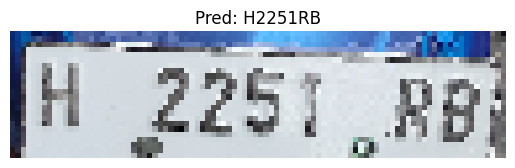

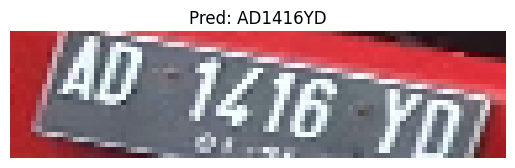

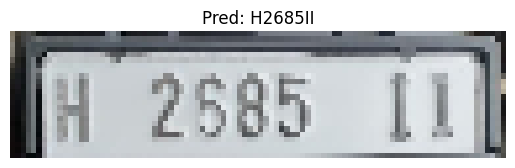

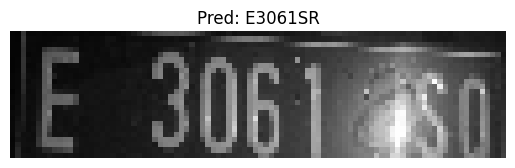

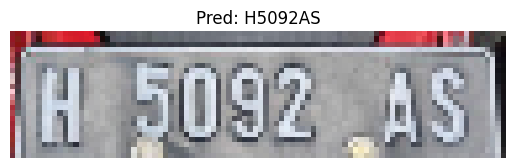

In [ ]:
def show_results(model, dataset, num=5):
    model.eval()
    encoder = LPRLabelEncoder(CHARS)
    
    indices = np.random.randint(0, len(dataset), num)
    
    for idx in indices:
        img_tensor, _, _ = dataset[idx]
        input_img = img_tensor.unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = model(input_img)
            pred_text = encoder.decode_greedy(logits)[0]
            
        # De-normalize for plotting
        display_img = img_tensor.numpy().transpose(1, 2, 0)
        display_img = (display_img / 0.0078125) + 127.5
        display_img = display_img.astype(np.uint8)
        
        plt.figure()
        plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Pred: {pred_text}")
        plt.axis('off')
        plt.show()

# Load Best Model
best_model_path = os.path.join(save_dir, "lprnet_best.pth")
if os.path.exists(best_model_path):
    print(f"Loading best model from: {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))
else:
    print("Best model not found, using last model.")

show_results(model, val_dataset)

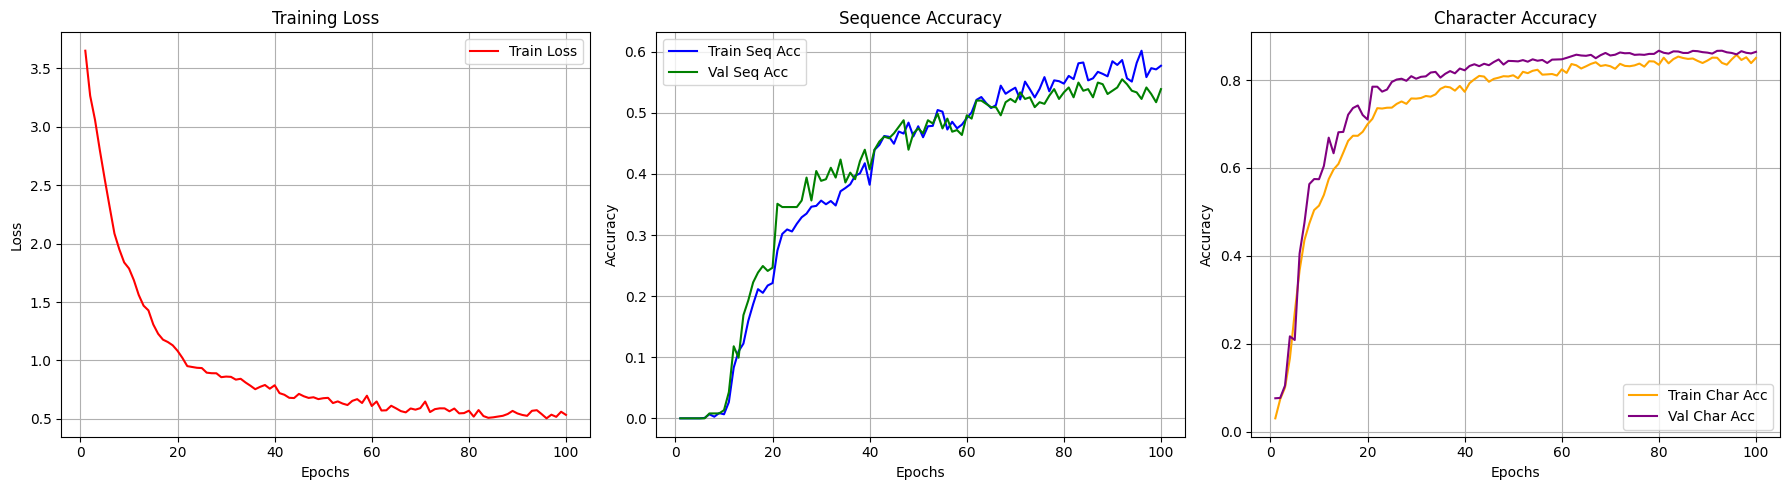

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    
    plt.figure(figsize=(18, 5))

    # 1. Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", color='red')
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # 2. Sequence Accuracy Plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_seq_acc"], label="Train Seq Acc", color='blue')
    plt.plot(epochs, history["val_seq_acc"], label="Val Seq Acc", color='green')
    plt.title("Sequence Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # 3. Character Accuracy Plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["train_char_acc"], label="Train Char Acc", color='orange')
    plt.plot(epochs, history["val_char_acc"], label="Val Char Acc", color='purple')
    plt.title("Character Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)